In [64]:
# import scipy.io
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import geopy.point as point
from tools import *
from scipy.spatial import distance
import scipy.io

In [65]:
location = 'london_square_20'
base = f'../Simulation/dataset/data_with_building/{location}_cell.mat'
# base = f'../Simulation/dataset/data_with_building/{location}_cell.mat'
meta_data_ld, cir_profile_ld, dist_ld, TX_ld, RX_ld = read_mat(base, location)

In [66]:
import scipy.io
meta_data_obs = scipy.io.loadmat('../Simulation/dataset/data_with_building/london_square_20_observation_cell.mat')

TX_obs = meta_data_obs['london_square_20_observation_cell'][0][0]['tx'].T
RX_obs = meta_data_obs['london_square_20_observation_cell'][0][0]['rx'].T
cir_observation = meta_data_obs['london_square_20_observation_cell']['cir'][0][0]

In [67]:
TX_obs = TX_ld
RX_obs = RX_ld
cir_observation = cir_profile_ld

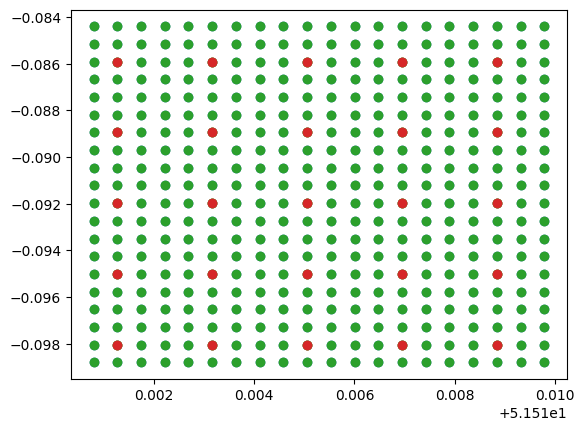

In [68]:
plot_agent(TX_ld)
plot_agent(RX_ld)
plot_agent(TX_obs)
plot_agent(RX_obs)

In [69]:
max_len = 5 # max number of reflections in a ray trace

# initiate an extractor
ext_ld = Extractor(cir_profile_ld)
# formatting CIR profiles
X_ld = ext_ld.formatting_X(max_len=max_len)

c:\Taf\WSN_simulation\Polished_code\tools.py:145: ComplexWarning: Casting complex values to real discards the imaginary part
  self.mag = - math.floor(math.log(np.mean(self.delay_set), 10))
c:\Taf\WSN_simulation\Polished_code\tools.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  cir_t.append(np.array(cir_shaped, dtype='float').flatten())


In [70]:
# data preparation for observations

# initiate an extractor
ext_ld_obs = Extractor(cir_observation)
# formatting CIR profiles
X_ld_obs = ext_ld_obs.formatting_X(max_len=max_len)

In [71]:
# load elevation data
ele_data = scipy.io.loadmat('../Simulation/dataset/ld_tx_ele.mat')['ld_tx_ele']

In [72]:
def noise_gen(x, snr=20):
    n = len(x)
    noise = np.random.randn(n)
    signal_power = np.sum(x*x) / n
    noise_power = np.sum(noise * noise) / n
    noise_var = signal_power / (10 ** (snr/10))
    noise_gaussian = np.sqrt(noise_var / noise_power) * noise
    return x + noise_gaussian

c:\Users\11740\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\histograms.py:839: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
c:\Users\11740\AppData\Local\Programs\Python\Python38\lib\site-packages\matplotlib\axes\_axes.py:6793: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


(array([6.9690e+03, 1.0148e+04, 6.4270e+03, 2.9680e+03, 1.4320e+03,
        5.4400e+02, 1.3800e+02, 3.0000e+01, 5.0000e+00, 2.0000e+00]),
 array([0.00000000e+00, 1.31098309e-06, 2.62196619e-06, 3.93294928e-06,
        5.24393237e-06, 6.55491547e-06, 7.86589856e-06, 9.17688165e-06,
        1.04878647e-05, 1.17988478e-05, 1.31098309e-05]),
 <BarContainer object of 10 artists>)

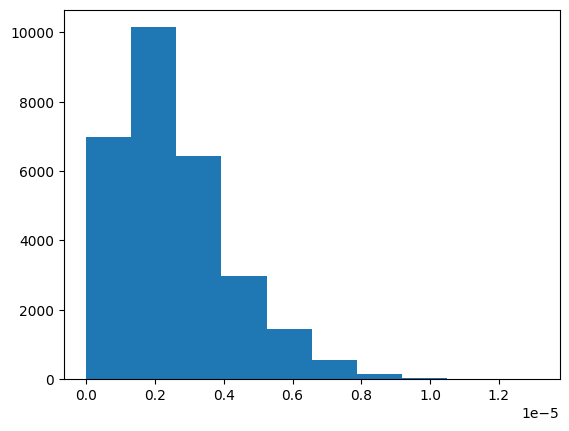

In [74]:
plt.hist(ext_ld.delay_set)

### Channel estimation


In [75]:
t_max = max(ext_ld.delay_set)

In [76]:
fc = 2e6 # sampling rate
W = 1e6

C:\Users\11740\AppData\Local\Temp\ipykernel_22060\1292930766.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  x = np.linspace(0,t_max, int(fc * t_max)+1)
C:\Users\11740\AppData\Local\Temp\ipykernel_22060\1292930766.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  t = np.linspace(0,t_max, int(fc * t_max)+1)
c:\Users\11740\AppData\Local\Programs\Python\Python38\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


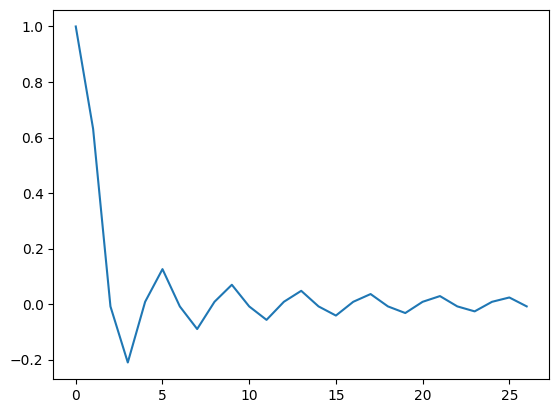

In [77]:
x = np.linspace(0,t_max, int(fc * t_max)+1)
t = np.linspace(0,t_max, int(fc * t_max)+1)
sinc_t = np.sinc(W * x)

plt.plot(sinc_t)

c:\Users\11740\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\ma\core.py:3371: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


<StemContainer object of 3 artists>

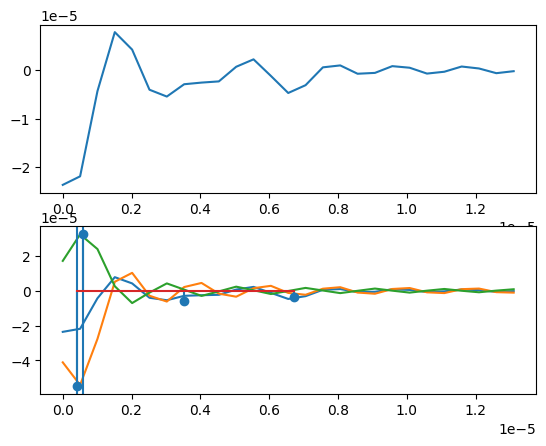

In [78]:
tau, amp = cir_profile_ld[3, 0].copy()
ans = np.repeat(x[:, None], len(tau), axis=1) - tau
y = np.sinc(W * ans) @ amp

_, axs = plt.subplots(2, 1)
axs[0].plot(x, y)
axs[1].plot(x, y)
axs[1].plot(x, amp[0] * np.sinc(W * (x-tau[0])))
axs[1].plot(x, amp[1] * np.sinc(W * (x-tau[1])))
axs[1].axvline(tau[0])
axs[1].axvline(tau[1])
axs[1].stem(tau, amp)

In [79]:
T, S = cir_profile_ld.shape
L = len(t)
cir_noise = []
cir_pure = []
snr = 40

cnt = 0
nan_idx = []

x_pre = []
for j in range(T):
    cir_t = [] # channel impulse response for a transmitter
    for i in range(S):
        status, _ = cir_profile_ld[j, i].shape
        if status == 1:
            x_n = np.repeat(np.nan, L)
            y = np.repeat(np.nan, L)
            cnt += 1
            nan_idx.append([j, i])
        else:
            tau, amp = cir_profile_ld[j, i].copy()
            ans = np.repeat(t[:, None], len(tau), axis=1) - tau
            y = np.sinc(W * ans) @ amp
            # c_tmp_noise = noise_gen(y, snr)
            n = len(y)
            noise = np.random.randn(n, 2).view(np.complex128)
            signal_power = np.sum(y * y) / n
            signal_db = 10 * np.log10(signal_power)
            noise_power = np.sum(noise * noise) / n
            noise_var = signal_power / (10 ** (snr/10))
            # noise_var = 10 ** ((signal_db - snr) / 10)
            # # print(noise_var)
            noise_gaussian = np.sqrt(noise_var / noise_power) * noise
            # noise_gaussian = np.random.normal(0, np.sqrt(noise_var), n).view(np.complex128)
            x_n = y + np.squeeze(noise_gaussian)

        cir_noise.append(x_n)
        cir_pure.append(y)

In [80]:
cir_pure[199].shape, cir_pure[1].shape

((27,), (27,))

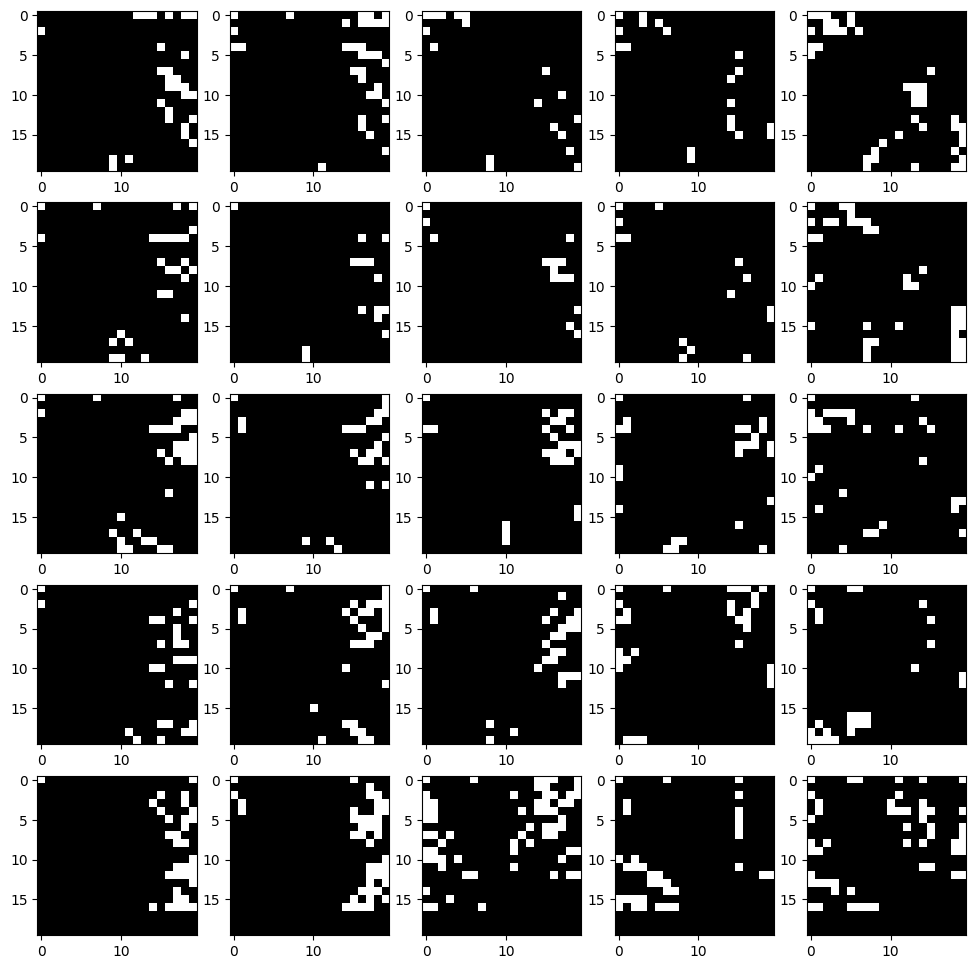

In [81]:
all_masks = []

_, axs = plt.subplots(5,5, figsize=(12, 12))

for rx_id in range(25):
    tx_id = [i[0] for i in nan_idx if i[1]==rx_id]
    x, y = [], []
    for t in tx_id:
        i, j = t//20, t%20
        x.append(i)
        y.append(j)
    mask = np.zeros((20, 20))
    mask[x, y] = 1
    all_masks.append(mask)
    axs[rx_id//5, rx_id%5].imshow(mask, cmap='gray')

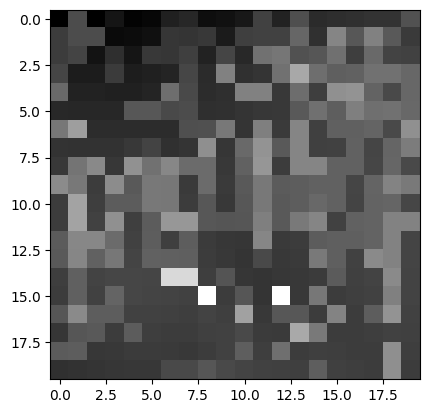

In [82]:
plt.imshow(ele_data, cmap='gray')

In [83]:
t = np.linspace(0,t_max, int(fc * t_max)+1)

C:\Users\11740\AppData\Local\Temp\ipykernel_22060\2097455578.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  t = np.linspace(0,t_max, int(fc * t_max)+1)


In [84]:
T, S = cir_profile_ld.shape
cir_full_noise = []
nan_idx = []
snr = 20

x_pre = []
for j in range(T):
    cir_t = [] # channel impulse response for a transmitter
    for i in range(S):
        status, _ = cir_profile_ld[j, i].shape
        if status == 1:
            x_n = np.zeros_like(t)
            y = x_n
            nan_idx.append([j, i])
        else:
            tau, amp = cir_profile_ld[j, i].copy()
            tau_noise = np.random.normal(np.real(tau), .05 * np.real(tau))
            ans = np.repeat(t[:, None], len(tau), axis=1) - tau_noise
            y = np.sinc(W * ans) @ amp
            # c_tmp_noise = noise_gen(y, snr)
            n = len(y)
            noise = np.random.randn(n, 2).view(np.complex128)
            signal_power = np.sum(y * y) / n
            signal_db = 10 * np.log10(signal_power)
            noise_power = np.sum(noise * noise) / n
            noise_var = signal_power / (10 ** (snr/10))
            # noise_var = 10 ** ((signal_db - snr) / 10)
            # # print(noise_var)
            noise_gaussian = np.sqrt(noise_var / noise_power) * noise
            # noise_gaussian = np.random.normal(0, np.sqrt(noise_var), n).view(np.complex128)
        x_n = y + np.squeeze(noise_gaussian)
        cir_full_noise.append(x_n)


In [85]:
def cir_brute(cir, snr=20):
    T, S = cir.shape
    cir_full_noise = []
    nan_idx = []
    x = np.linspace(0,t_max, int(fc * t_max)+1)

    for j in range(T):
        cir_t = [] # channel impulse response for a transmitter
        for i in range(S):
            status, _ = cir[j, i].shape
            if status == 1:
                x_n = np.zeros_like(t)
                y = x_n
                nan_idx.append([j, i])
            else:
                tau, amp = cir[j, i].copy()
                tau_noise = np.random.normal(np.real(tau), .05 * np.real(tau))
                ans = np.repeat(x[:, None], len(tau), axis=1) - tau_noise
                y = np.sinc(W * ans) @ amp
                # c_tmp_noise = noise_gen(y, snr)
                n = len(y)
                noise = np.random.randn(n, 2).view(np.complex128)
                signal_power = np.sum(y * y) / n
                signal_db = 10 * np.log10(signal_power)
                noise_power = np.sum(noise * noise) / n
                noise_var = signal_power / (10 ** (snr/10))
                # noise_var = 10 ** ((signal_db - snr) / 10)
                # # print(noise_var)
                noise_gaussian = np.sqrt(noise_var / noise_power) * noise
                # noise_gaussian = np.random.normal(0, np.sqrt(noise_var), n).view(np.complex128)
            x_n = y + np.squeeze(noise_gaussian)
            cir_full_noise.append(x_n)
    return cir_full_noise


In [86]:
cir_full_noise_obs = cir_brute(cir_observation)

C:\Users\11740\AppData\Local\Temp\ipykernel_22060\4137990550.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  x = np.linspace(0,t_max, int(fc * t_max)+1)


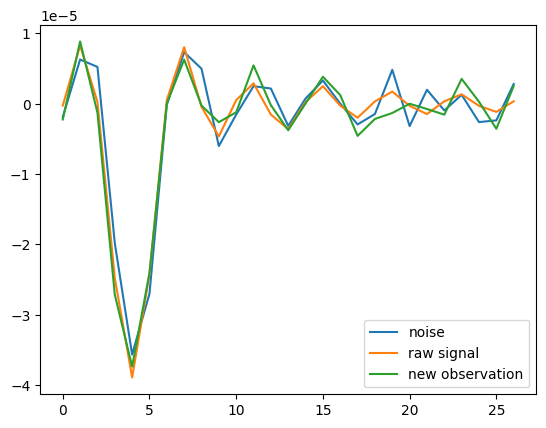

In [87]:
ind = np.random.choice(len(cir_full_noise_obs))
plt.plot(cir_full_noise[ind], label='noise')
plt.plot(cir_pure[ind], label='raw signal')
plt.plot(cir_full_noise_obs[ind], label='new observation')
plt.legend()

In [88]:
cirs_noise = np.array(cir_noise)
cirs_pure = np.array(cir_pure)
cirs_full_noise = np.array(cir_full_noise)
cirs_full_noise_obs = np.array(cir_full_noise_obs)
m = len(cirs_full_noise)

In [111]:
order = [i[0]*20 + i[1] for i in nan_idx] # index of nan tx
t = np.linspace(0,t_max, int(fc * t_max)+1)

C:\Users\11740\AppData\Local\Temp\ipykernel_22060\1586769000.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  t = np.linspace(0,t_max, int(fc * t_max)+1)


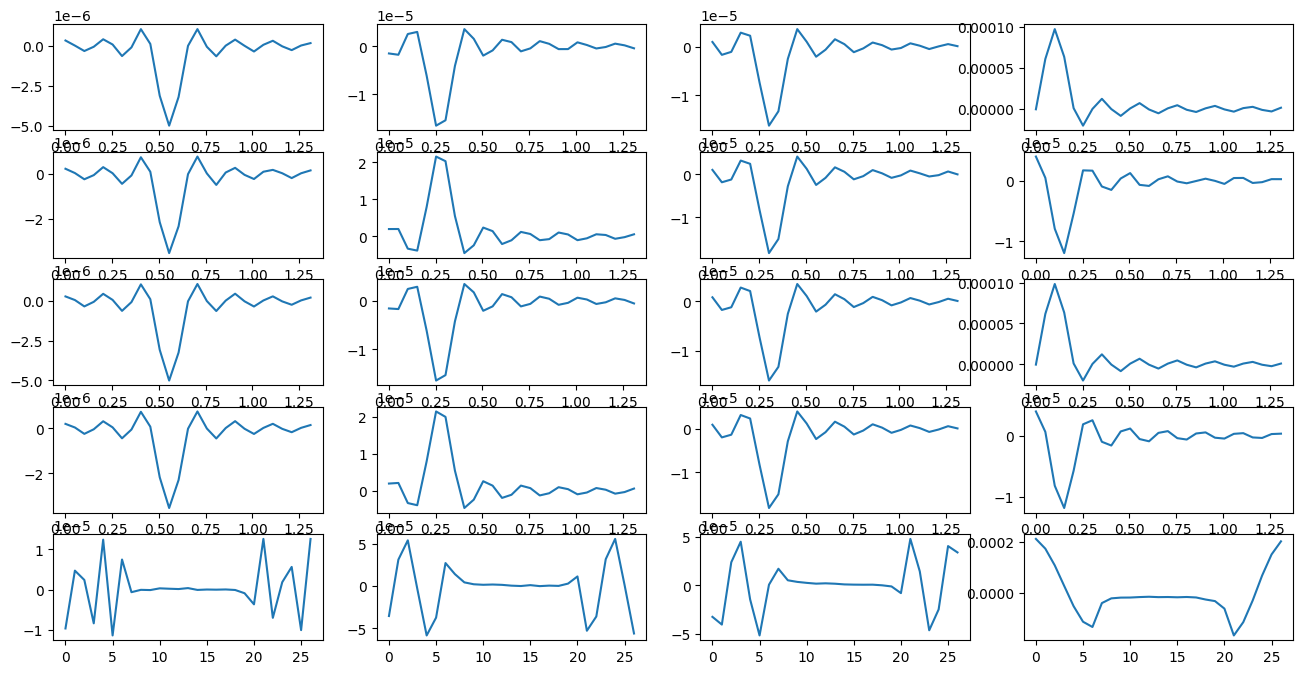

In [90]:
# idx = np.random.choice(m, 4)
idx = np.random.choice([x for x in range(m) if x not in order], 4)
fig, axs = plt.subplots(5, len(idx), figsize=(16,8))
for ax, id in zip(axs[0], idx):
    ax.plot(t, np.real(cirs_noise[id]))

for ax, id in zip(axs[1], idx):
    ax.plot(t, np.imag(cirs_noise[id]))

for ax, id in zip(axs[2], idx):
    ax.plot(t, np.real(cirs_pure[id]))

for ax, id in zip(axs[3], idx):
    ax.plot(t, np.imag(cirs_pure[id]))   

for ax, id in zip(axs[4], idx):
    ax.plot(np.fft.fft(cirs_noise[id]))

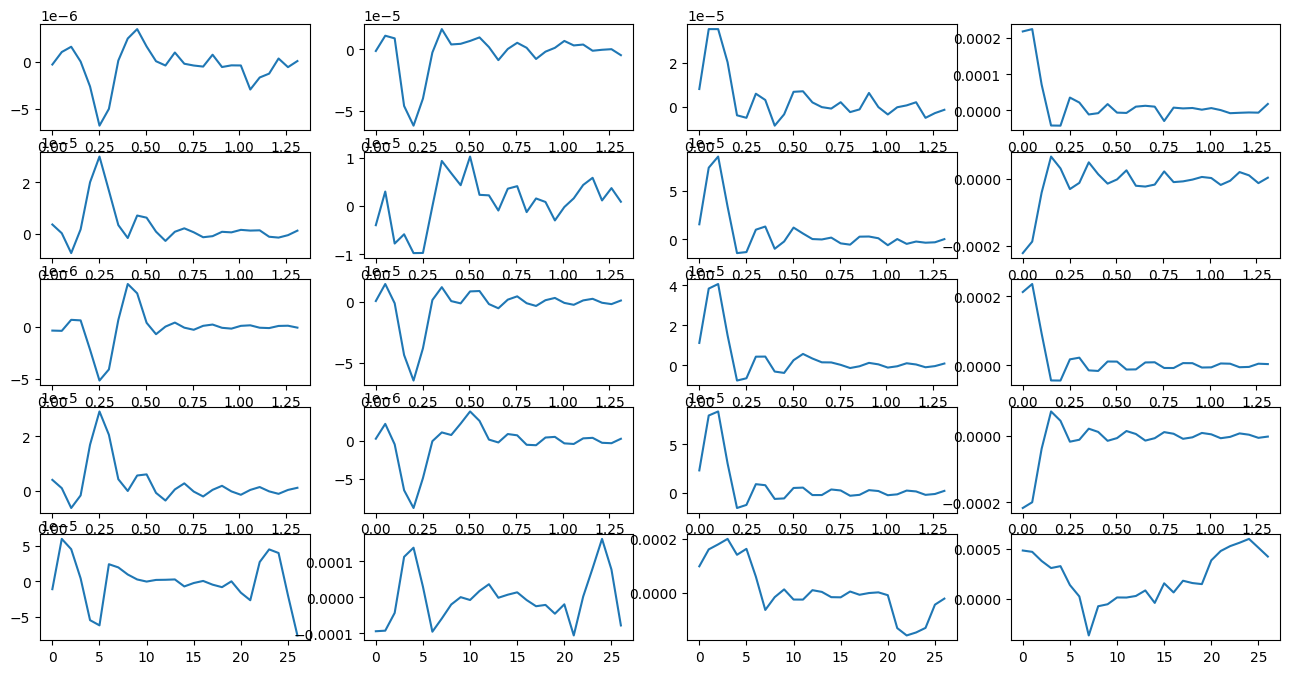

In [91]:
idx = np.random.choice(m, 4)
fig, axs = plt.subplots(5, len(idx), figsize=(16,8))
for ax, id in zip(axs[0], idx):
    ax.plot(t, np.real(cirs_full_noise[id]))

for ax, id in zip(axs[1], idx):
    ax.plot(t, np.imag(cirs_full_noise[id]))

for ax, id in zip(axs[2], idx):
    ax.plot(t, np.real(cirs_pure[id]))

for ax, id in zip(axs[3], idx):
    ax.plot(t, np.imag(cirs_pure[id]))   

for ax, id in zip(axs[4], idx):
    ax.plot(np.fft.fft(cirs_full_noise[id]))

In [110]:
# plt.plot(t, np.sinc(W * (np.repeat(t[:, None], len(tau), axis=1) - tau)) @ amp)
# np.sinc(W * (np.repeat(t[:, None], len(tau), axis=1) - tau))
# np.repeat(t[:, None], len(tau), axis=1)
t

(6.916483742005076e-06+0j)

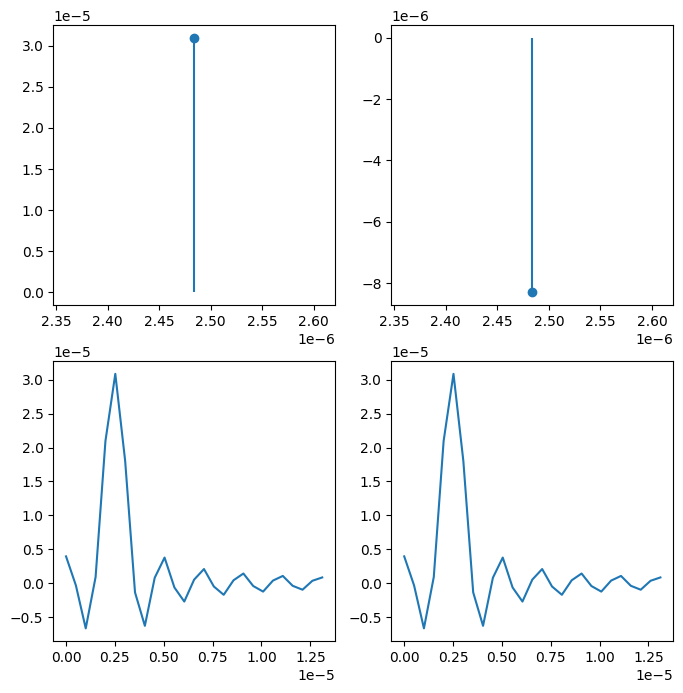

In [113]:
fig, axs = plt.subplots(2,2, figsize=(8,8))
tt, s = np.random.choice(T), np.random.choice(S)
# t,s = 397, 7
tau, amp = cir_profile_ld[tt, s]
axs[0, 0].stem(tau, np.real(amp))
axs[0, 1].stem(tau, np.imag(amp))
for ttt, a in zip(tau, amp):
    axs[1, 0].plot(t, a * np.sinc(W * (t-ttt)))
# axs[1, 0].plot(x, amp[0] * np.sinc(W * (x-tau[0])))
# axs[1, 0].plot(x, amp[1] * np.sinc(W * (x-tau[1])))
# axs[1, 0].plot(x, amp[2] * np.sinc(W * (x-tau[2])))
# axs[1, 0].plot(x, amp[3] * np.sinc(W * (x-tau[3])))
axs[1, 1].plot(t, np.sinc(W * (np.repeat(t[:, None], len(tau), axis=1) - tau)) @ amp)
# axs[1,0].set_yscale('log')

### data preparation

In [114]:
cirs_noise_shaped = cirs_noise.reshape(T, -1)
cirs_full_noise_shaped = cirs_full_noise.reshape(T, -1)
cirs_full_noise_shaped_obs = cirs_full_noise_obs.reshape(T, -1)

In [276]:
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("D:/Social_life//RA//pics//output.pdf")

In [ ]:
# i = np.arange(20)
# j = np.arange(20)
# for i in range(10):
cnt = 0
for i in range(20):
    fig, axs = plt.subplots(20, 1, figsize=(11.69,8.27))
    for j in range(20):
        axs[j].plot(np.real(cirs_full_noise_shaped[i*20+j]))
        axs[j].set_ylabel(i*20+j)
        axs[j].set_yticklabels([])
        axs[j].set_xticklabels([])
        cnt += 1
        plt.savefig(f'D:/Social_life//RA//pics//{i*20}~{i*20+19}.pdf')
        # pdf.savefig(fig)

# pdf.close()

In [ ]:
# i = np.arange(20)
# j = np.arange(20)
# for i in range(10):
cnt = 0
for i in range(20):
    fig, axs = plt.subplots(20, 1, figsize=(11.69,8.27))
    for j in range(20):
        axs[j].plot(np.real(cirs_full_noise_shaped_obs[i*20+j]))
        axs[j].set_ylabel(i*20+j)
        axs[j].set_yticklabels([])
        axs[j].set_xticklabels([])
        cnt += 1
        plt.savefig(f'D:/Social_life//RA//pics//observation_{i*20}~{i*20+19}.pdf')
        # pdf.savefig(fig)

# pdf.close()

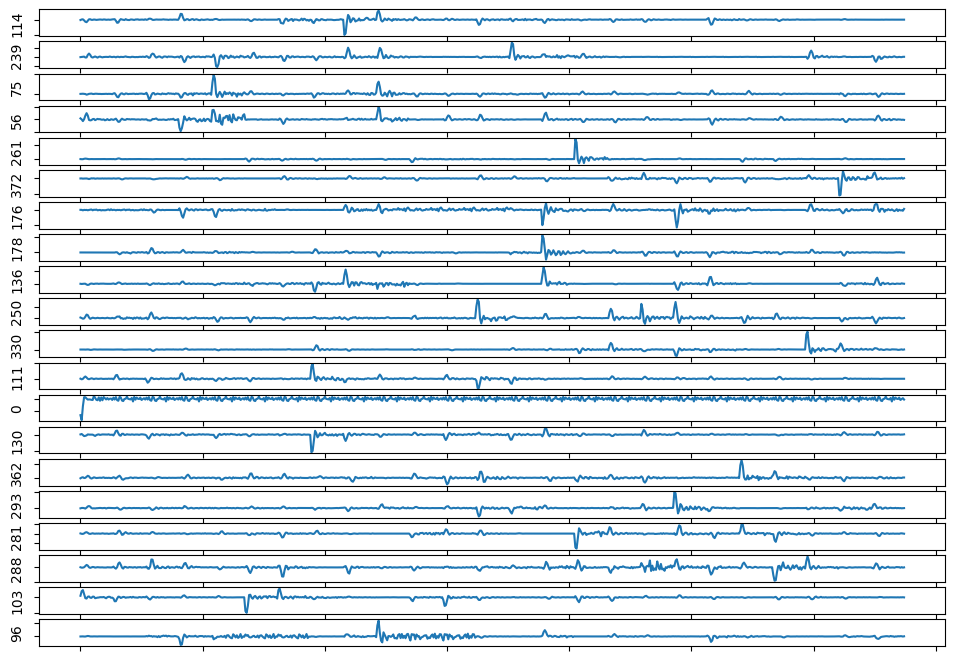

In [73]:
fig, axs = plt.subplots(20, 1, figsize=(11.69,8.27))
# i = np.arange(20)
# j = np.arange(20)
idx = np.random.choice([x for x in range(len(cirs_full_noise_shaped)) if x not in order], 20)
# for i in range(10):
cnt = 0
for i in idx:
    axs[cnt].plot(np.real(cirs_full_noise_shaped[i]))
    axs[cnt].set_ylabel(i)
    axs[cnt].set_yticklabels([])
    axs[cnt].set_xticklabels([])
    cnt += 1
# plt.savefig(f'D:/Social_life//RA//pics//1.pdf')
# axs[0, 0].plot(np.real(cirs_noise_shaped[0]))
# axs[1, 0].plot(np.real(cirs_noise_shaped[0, 0:len(x)]))
# axs[2, 0].plot(np.real(cirs_noise_shaped[0, -len(x):]))

# axs[0, 1].plot(np.imag(cirs_noise_shaped[0]))
# axs[1, 1].plot(np.imag(cirs_noise_shaped[0, 0:len(x)]))
# axs[2, 1].plot(np.imag(cirs_noise_shaped[0, -len(x):]))

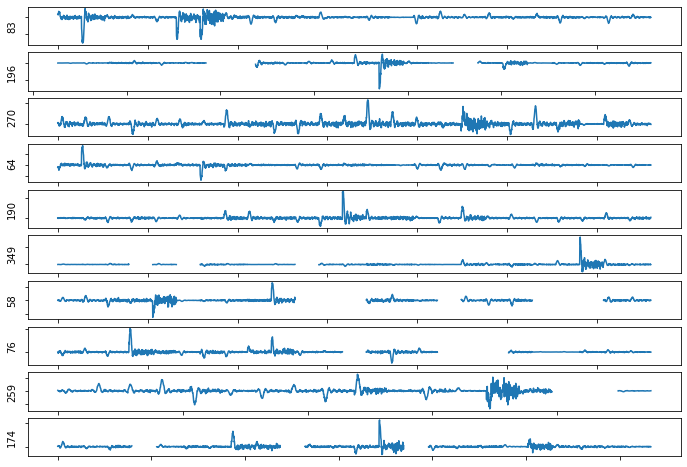

In [273]:
fig, axs = plt.subplots(20, 1, figsize=(11.69,8.27))
# i = np.arange(20)
# j = np.arange(20)
idx = np.random.choice([x for x in range(len(cirs_full_noise_shaped)) if x not in order], 10)
# for i in range(10):
cnt = 0
for i in idx:
    axs[cnt].plot(np.real(cirs_full_noise_shaped[i]))
    axs[cnt].set_ylabel(i)
    axs[cnt].set_yticklabels([])
    axs[cnt].set_xticklabels([])
    cnt += 1
# plt.savefig(f'D:/Social_life//RA//pics//1.pdf')
# axs[0, 0].plot(np.real(cirs_noise_shaped[0]))
# axs[1, 0].plot(np.real(cirs_noise_shaped[0, 0:len(x)]))
# axs[2, 0].plot(np.real(cirs_noise_shaped[0, -len(x):]))

# axs[0, 1].plot(np.imag(cirs_noise_shaped[0]))
# axs[1, 1].plot(np.imag(cirs_noise_shaped[0, 0:len(x)]))
# axs[2, 1].plot(np.imag(cirs_noise_shaped[0, -len(x):]))

### Triplet pairs

In [93]:
t, TX_ld[0]

(array([51.51049273, -0.09910457]), array([51.5108, -0.0988]))

In [97]:
t = TX_obs[0]
d = [geodesic(t, tx_raw).m for tx_raw in TX_ld]
np.argmax(d), np.argmin(d)

(399, 0)

In [76]:
a= [ 45, 1, 2,4]
sorted(a)

[1, 2, 4, 45]

In [34]:
triplets = []
n = 10
anchor, pos, neg = [], [], []

for i in range(len(TX_obs)):
     tx_obs = TX_obs[i] # location of observed tx
     dist_ls = [geodesic(tx_obs, tx_raw) for tx_raw in TX_ld] # distance of the observed tx to all recorded TX 
     # sim_ind, dissim_ind = np.argmin(dist_ls), np.argmax(dist_ls) # index of similar and dissimilar features in dataset
     sim_ind = [dist_ls.index(i) for i in sorted(dist_ls, reverse=False)][1:n+1] # excluding the index of tx itself
     dissim_ind = [dist_ls.index(i) for i in sorted(dist_ls, reverse=False)][n+1:]
     triplets.append((i, sim_ind, dissim_ind))
     anchor.append(i)
     pos.append(sim_ind)
     neg.append(dissim_ind)

In [38]:
[dist_ls.index(b) for b in sorted(dist_ls, reverse=False)][:n]

[378, 379, 398, 358, 399, 377, 359, 397, 357, 338]

(399, [379, 398, 358, 399, 377, 359, 397, 357, 338, 376])

In [36]:
np.save('./metric_learning_data/anchor_idx.npy', anchor)
np.save('./metric_learning_data/pos_idx.npy', pos)
np.save('./metric_learning_data/neg_idx.npy', neg)

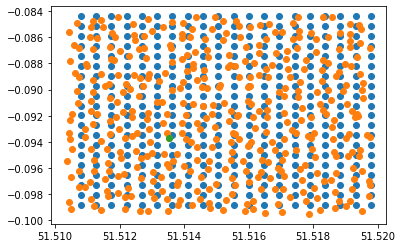

In [114]:
plot_agent(TX_ld)
plot_agent(TX_obs)
plt.scatter(TX_obs[ind][0], TX_obs[ind][1])

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


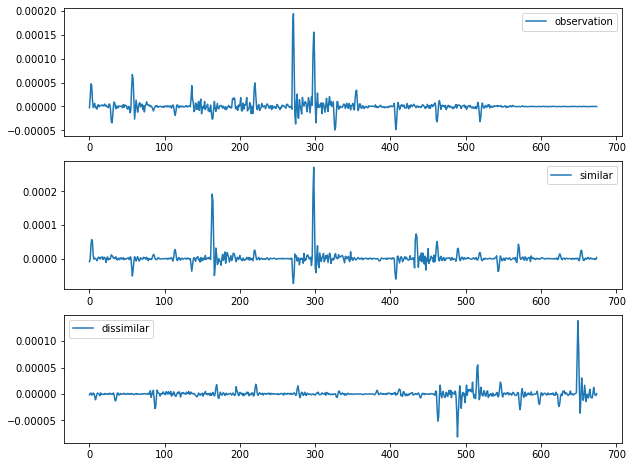

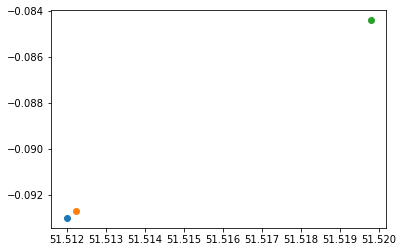

: 

In [138]:
ind = np.random.choice(len(triplets))
fig, axs = plt.subplots(3,1,figsize=(10, 8))

axs[0].plot(cirs_full_noise_shaped_obs[triplets[ind][0]], label='observation')
axs[1].plot(cirs_full_noise_shaped[triplets[ind][1]], label='similar')
axs[2].plot(cirs_full_noise_shaped[triplets[ind][2]], label='dissimilar')
axs[0].legend()
axs[1].legend()
axs[2].legend()


plt.figure()
# plot_agent(TX_ld)
# plot_agent(TX_obs)
plt.scatter(TX_obs[triplets[ind][0]][0], TX_obs[triplets[ind][0]][1], label='observation')
plt.scatter(TX_ld[triplets[ind][1]][0], TX_ld[triplets[ind][1]][1], label='similar')
plt.scatter(TX_ld[triplets[ind][2]][0], TX_ld[triplets[ind][2]][1], label='dissimilar')
# plt.imshow(ele_data)

In [115]:
# np.save( './metric_learning_data/cirs_noised_ld.npy', cirs_full_noise_shaped)
np.save('./metric_learning_data/cirs_observation_ld_exact.npy', cirs_full_noise_shaped_obs)
# np.save('./metric_learning_data/triplets_ld.npy', triplets)

### Cosine similarity

In [116]:
cirs_full_noise_shaped[np.isnan(cirs_full_noise_shaped)]=0

In [118]:
cosine_matrix = distance.cdist(np.real(cirs_full_noise_shaped), np.real(cirs_full_noise_shaped))

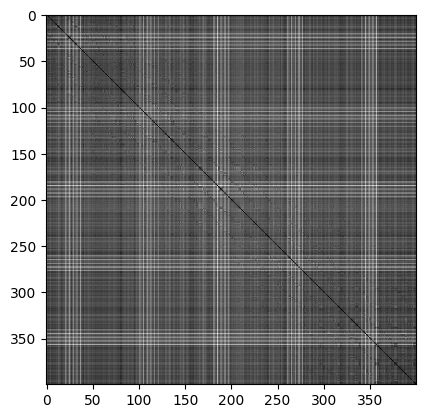

In [119]:
plt.imshow(cosine_matrix, cmap='gray')

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\collections.py:153: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


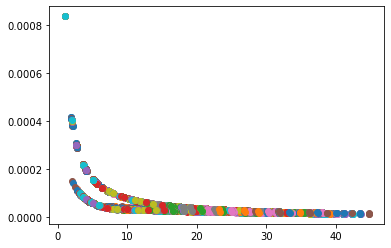

In [222]:
T, S = cir_profile_ld.shape
cir_noise = []

x_pre = []
for j in range(T):
    cir_t = [] # channel impulse response for a transmitter
    for i in range(S):
        c_tmp = cir_profile_ld[j, i].copy()
        c_tmp[0, :] = c_tmp[0, :] * 10 ** 7 # normalize the delay seconds
        
        m, n = c_tmp.shape
        if m == 2:
            c_tmp[1, :] = abs(c_tmp[1, :])
        
        # cir_normal.
        c_tmp_noise = noise_gen(c_tmp[1,:], 5)
        cir_noise.append(c_tmp_noise)
        plt.scatter(c_tmp[0, :], c_tmp[1, :])

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is sepa

<StemContainer object of 3 artists>

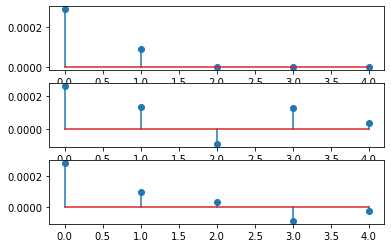

In [28]:
fig, axs = plt.subplots(3,1)
axs[0].stem(cir_normal[0])
axs[1].stem(cir_noise[0])
axs[2].stem(cir_noise_10[0])

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

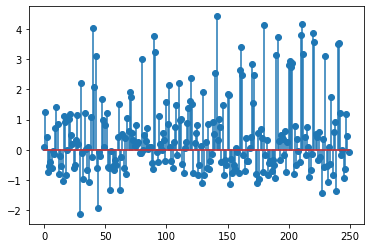

In [219]:
plt.stem(x_noise)

In [9]:
cir_array = np.array(cir_noise)
cir_normal_array = np.array(cir_normal)
cir_noise_10_array = np.array(cir_noise_10)

In [10]:
new_cir = cir_array.reshape(T, -1)
new_cir_normal = cir_normal_array.reshape(T, -1)
new_cir_10 = cir_noise_10_array.reshape(T, -1)

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection in

<StemContainer object of 3 artists>

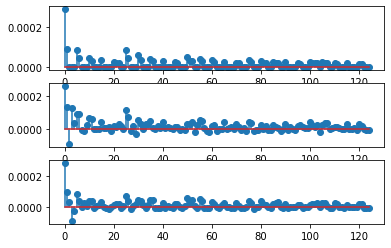

In [31]:
fig, axs = plt.subplots(3,1)
axs[0].stem(new_cir_normal[0], label='raw')
axs[1].stem(new_cir[0])
axs[2].stem(new_cir_10[0])

### Cosine similarity

In [11]:
dist_matrix_cos_10 = np.exp(-distance.cdist(new_cir, new_cir_10, 'cosine'))

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\spatial\distance.py:184: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.ascontiguousarray(X, dtype=out_type)


In [12]:
dist_matrix_cir_normal = np.exp(-distance.cdist(new_cir_normal, new_cir_normal, 'cosine'))

In [13]:
dist_matrix_cos_1010 = np.exp(-distance.cdist(new_cir_10, new_cir_10, 'cosine'))

In [14]:
dist_matrix_cos = np.exp(-distance.cdist(new_cir, new_cir, 'cosine'))

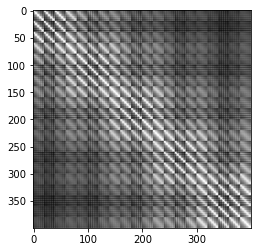

In [15]:
plt.imshow(dist_matrix_cir_normal, cmap='gray')

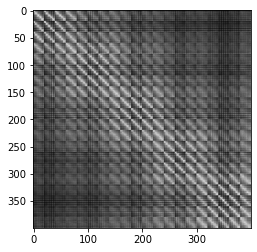

In [16]:
plt.imshow(dist_matrix_cos_10,cmap='gray')

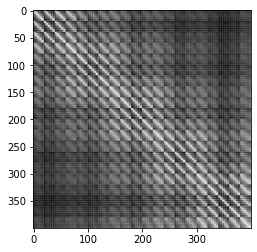

In [17]:
plt.imshow(dist_matrix_cos_1010,cmap='gray')

In [215]:
ind = np.random.randint(T)
ind = 108

In [216]:
def find_max(img):
    x, y = np.unravel_index(np.argmax(img, axis=None),np.shape(img))
    return  x, y

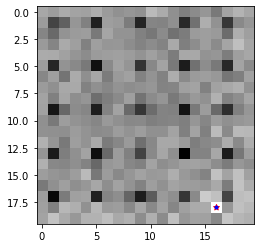

In [238]:
ind = np.random.randint(T)
mask = np.zeros((20, 20))
i, j = ind//20, ind%20
mask[i, j] = 10
# plt.imshow(ind//20, ind%20)
# fig, ax = plt.subplots()
img = np.exp(-cosine_matrix[ind, :]).reshape(20, 20)
x_cos, y_cos = find_max(img)
plt.imshow(img, cmap='gray')
plt.scatter(j, i, c='red', marker='*')
plt.scatter(y_cos, x_cos, c='b', marker='.')

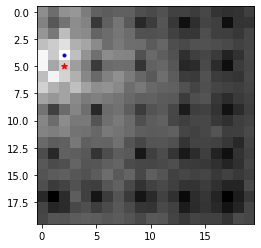

In [21]:
ind = np.random.randint(T)
mask = np.zeros((20, 20))
i, j = ind//20, ind%20
mask[i, j] = 10
# plt.imshow(ind//20, ind%20)
# fig, ax = plt.subplots()
img = dist_matrix_cos_10[ind, :].reshape(20, 20)
x_cos, y_cos = find_max(img)
plt.imshow(img, cmap='gray')
plt.scatter(j, i, c='red', marker='*')
plt.scatter(y_cos, x_cos, c='b', marker='.')

In [22]:
coord_ls_cos = []
dist_ls_cos = []

for i in range(len(dist_matrix_cos_10)):
    img = np.reshape(dist_matrix_cos_10[i, :], (20,20))
    x_tmp, y_tmp = find_max(img)
    ind_x, ind_y = i//20, i%20
    dist_ls_cos.append(50 * np.linalg.norm([x_tmp - ind_x, y_tmp - ind_y]))


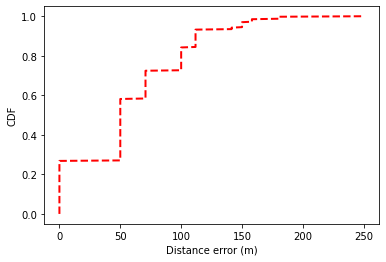

In [23]:
n = len(dist_ls_cos)
x = np.arange(n) / (n-1)
y = np.sort(dist_ls_cos)
plt.xlabel('Distance error (m)')
plt.ylabel('CDF')
plt.plot(y, x, '--', linewidth=2, color='r')

### XGBoost

In [32]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.pipeline import Pipeline
import seaborn as sns
import lightgbm as lgb
import itertools
import warnings


In [34]:
warnings.filterwarnings('ignore')

In [25]:
xgb_pipe = Pipeline([('scale', StandardScaler()), \
    ('xgb', xgb.XGBRegressor(n_estimators=500, eta=0.1, subsample=1, colsample_bytree=1, reg_lambda=0))])

In [26]:
train_set = []
label = []
for i in range(len(new_cir)):
    for j in range(i, len(new_cir)):
        train_set.append(np.concatenate([new_cir[i], new_cir[j]]))
        label.append(np.exp(-distance.cosine(new_cir[i], new_cir[j])))

In [27]:
train_set = np.array(train_set).astype(float)
label= np.array(label).astype(float)

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


In [28]:
all_train = list(itertools.combinations(new_cir,2))

In [29]:
cir_train = np.array(all_train).reshape(79800, 250).astype(float)

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


In [30]:
dist_train = dist_matrix_cos[np.triu_indices_from(dist_matrix_cos, k=1)]

In [31]:
xgb_pipe.fit(train_set, label)

Pipeline(steps=[('scale', StandardScaler()),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              eta=0.1, gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.100000001, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=500,
                              n_jobs=12, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=0, reg_lambda=0,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [411]:
s1 = np.concatenate([new_cir_10[ind], new_cir[0]]).astype(float).reshape(1, -1)
s2 = np.concatenate([new_cir_10[ind], new_cir[ind]]).astype(float).reshape(1, -1)

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [117]:
xgb_pipe.predict(tmp.astype(float))

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


array([0.775791], dtype=float32)

In [327]:
pdf = []
for i in new_cir:
    tmp = np.concatenate([i, new_cir_10[ind]]).reshape(1, -1)
    s = xgb_pipe.predict(tmp.astype(float))
    pdf.append(s)

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from 

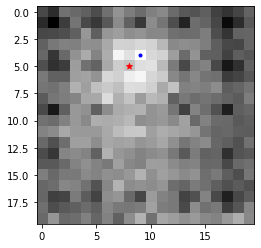

In [328]:
ind = 108
xgb_heat = np.array(pdf).reshape(20, 20)
i, j = ind//20, ind%20
x, y = np.unravel_index(np.argmax(xgb_heat, axis=None), xgb_heat.shape)
plt.imshow(xgb_heat, cmap='gray')
plt.scatter(j, i, c='red', marker='*')
plt.scatter(y, x, c='b', marker='.')

##### CDF for xgb method

In [35]:
from tqdm import tqdm

In [36]:
# pdf = []
dist_ls_xgb = []

for i in tqdm(range(len(new_cir))):
    s_ls = []
    for j in range(len(new_cir_10)):
        tmp = np.concatenate([new_cir[i], new_cir_10[j]]).reshape(1, -1)
        s = xgb_pipe.predict(tmp.astype(float))
        s_ls.append(s)
    img = np.reshape(s_ls, (20,20))
    x_xgb, y_xgb = i // 20, i % 20
    x_tmp, y_tmp = find_max(img)
    dist_ls_xgb.append(50 * np.linalg.norm([x_xgb-x_tmp, y_xgb-y_tmp]))
        # pdf.append(s)

100%|██████████| 400/400 [09:13<00:00,  1.38s/it]


399

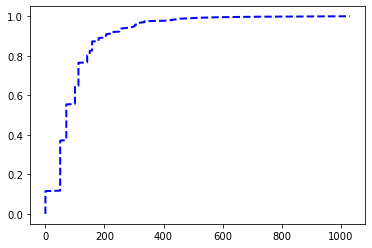

In [37]:
# n = len(data)
x = np.arange(n) / (n-1) 
y_xgb = np.sort(dist_ls_xgb)
# ax.set_xlabel('Distance error (m)')
# ax.set_y('CDF')
plt.plot(y_xgb, x, '--',label=label, linewidth=2, color='b')

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

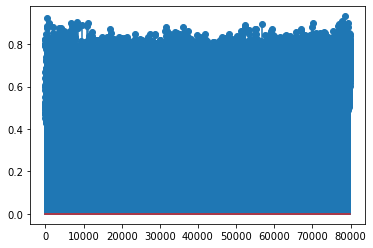

In [394]:
plt.stem(dist_train)

### Mahalanobis Distance

In [41]:
S = np.cov(new_cir.T)

In [74]:
ind = 108

In [71]:
inp = new_cir_10[ind]

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


In [111]:
pdf = []
d_ls = []
for i in new_cir:
    s = (inp - i).T @ np.linalg.inv(S) @ (inp - i)
    pdf.append(np.exp(-s.astype(float)))
    d_ls.append(s.astype(float))

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


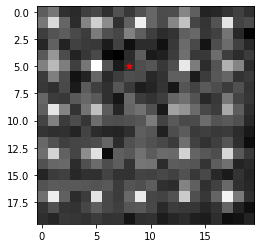

In [125]:
ma_heat = np.array(d_ls).reshape(20, 20)
i, j = ind//20, ind%20
plt.imshow(ma_heat, cmap='gray')
plt.scatter(j, i, c='red', marker='*')

In [243]:
from metric_learn import NCA, MMC, ITML, MLKR

### ITML

In [215]:
train_set_metric = []
train_set_mlkr = []
label_metric = []
for i in range(len(new_cir)):
    # for j in range(i, len(new_cir)):
    # train_set_mlkr.append((new_cir[i]-new_cir[j]).astype(float))
    train_set_metric.append(np.array([new_cir[i], new_cir[i]]))
    label_metric.append(1)
    train_set_metric.append(np.array([new_cir[i], new_cir[(i+200)%400]]))
    label_metric.append(-1)

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [173]:
train_set_metric = np.array(train_set_metric).astype(float)
# train_set_metric = np.transpose(train_set_metric, (0,2,1))

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


In [166]:
train_set_metric.shape, len(label_metric)
# train_set_metric[0]

((800, 125, 2), 800)

In [208]:
itml = ITML()

itml.fit(train_set_metric, label_metric)

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\metric_learn\itml.py:35: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  X = np.vstack({tuple(row) for row in pairs.reshape(-1, pairs.shape[2])})
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\metric_learn\itml.py:66: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = min(_lambda[i], gamma_proj * (1. / wtw - 1. / pos_bhat[i]))


ITML()

In [ ]:
mahal = itml.get_mahalanobis_matrix()

#### MLKR

In [ ]:
train_set_mlkr = []
label_mlkr = []
for i in range(len(new_cir)):
    for j in range(i, len(new_cir)):
        train_set_mlkr.append(np.concatenate([new_cir[i], new_cir[j]]).astype(float))
        label_mlkr.append(distance.cosine(new_cir[i], new_cir[j]))

In [280]:
mlkr = MLKR()
indices = np.random.choice(len(label_mlkr),size=8000)
mlkr.fit(np.array(train_set_mlkr)[indices], np.array(label_mlkr)[indices])

MLKR()

In [281]:
mahal_mlkr = mlkr.get_mahalanobis_matrix()

In [210]:
score_ls = []

for i in new_cir:
    score = (new_cir_10[ind]-i).T @ mahal @ (new_cir_10[ind]-i)
    score_ls.append(np.exp(-score))

In [309]:
score_ls_mlkr = []

for i in new_cir:
    # score_mlkr = (new_cir_10[ind]-i).T @ mahal_mlkr @ (new_cir_10[ind]-i)
    v = np.concatenate([new_cir_10[ind], i])
    score_ls_mlkr.append(np.linalg.norm(v.T @ mahal_mlkr, 2))

In [235]:
mlkr.transform(new_cir[0].astype(float).reshape(1,-1)).shape

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


(1, 125)

In [304]:
np.shape(score_ls_mlkr)


(5, 5)

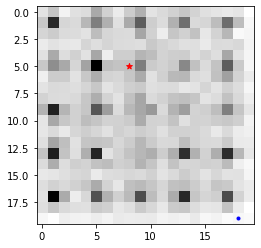

In [310]:
maha_heat = np.array(score_ls_mlkr).astype(float).reshape(20, 20)
i, j = ind//20, ind%20
x, y = find_max(-maha_heat)
plt.imshow(np.exp(-maha_heat), cmap='gray')
plt.scatter(j, i, c='red', marker='*')
plt.scatter(x, y, c='b', marker='.')